In [48]:
import pandas as pd
import datetime
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

In [49]:
def DEVSTimeToMinutes(aDEVSTime):
    """
    Converts a DEVS timestamp, of the form hours:minutes:seconds:miliseconds:sth
    to a python datetime object, starting with year 1990 on.
    """
    START_YEAR = 1990
    
    splittedDate = aDEVSTime.split(':')
    # Normal assert
    hours = int(splittedDate[0])
    minutes = int(splittedDate[1])
    seconds = int(splittedDate[2])
    mseconds = int(splittedDate[3])
    
    return minutes + hours * 60

## Assumptions

It is assumed the the output being parsed was generated with the following top model: **models/controllerAndSolar.ma**. This contains three output ports:
- **grid_out**: Power demanded on sold to the grid. 
- **controlBatteryState**: Battery state changes.
- **controlBatteryDemand**: Power demanded from the controller to the battery.

In [50]:
outputFile = open('../simulation/src/out/realData', 'r')

parsedOutput = []
for line in outputFile:
    # Trim newline character from read line
    line = line[:-1]
    # Split by spaces
    splittedLine = line.split(' ')
    # Drop excedent emoty read parts
    splittedLine = [readPart for readPart in splittedLine if readPart != '']
    parsedOutput.append(splittedLine)

In [51]:
parsedData = pd.DataFrame(data=parsedOutput, columns=['time', 'port', 'value'])
parsedData.loc[:, 'value'] = parsedData.value.astype(float)
parsedData.loc[:, 'time'] = parsedData.time.map(DEVSTimeToMinutes)

In [52]:
parsedData.columns

Index(['time', 'port', 'value'], dtype='object')

In [53]:
parsedData.port.unique()

array(['solarpowerbeinggenerated', 'grid_out', 'controlbatterystate',
       'controlbatterydemand'], dtype=object)

In [54]:
gridOutData = parsedData[parsedData.port == 'grid_out']
generatedSolarPower = parsedData[parsedData.port == 'solarpowerbeinggenerated']
batteryDemand = parsedData[parsedData.port == 'controlbatterydemand']

In [55]:
batteryDemand.describe()

,time,value
count,194.000000,194.000000
mean,2002.025773,421.804124
std,1053.202648,146.210944
min,575.000000,0.000000
25%,779.000000,474.500000
50%,2166.500000,500.000000
75%,2289.750000,500.000000
max,3714.000000,500.000000


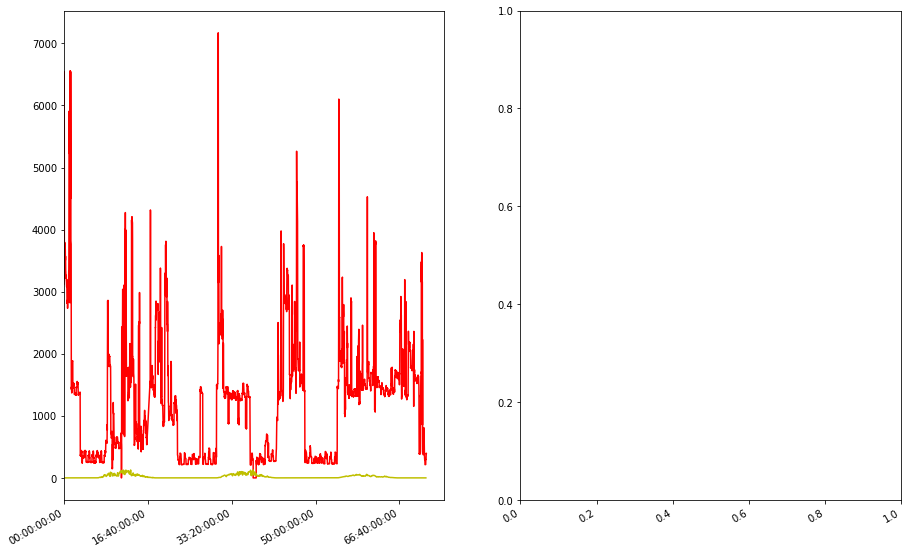

In [56]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (15,10))

import math

# Custom axis formatter
def format_date(x, pos=None):
    hours = math.floor(x / 60)
    minutes = x - hours*60
    
    return '%02d:%02d:00:00' % (hours,minutes)

ax[0].plot(gridOutData.time, gridOutData.value, color='r')
ax[0].plot(generatedSolarPower.time, generatedSolarPower.value, color='y')

ax[0].set_xlim(left=0)
ax[0].xaxis.set_major_formatter(ticker.FuncFormatter(format_date))

ax[1].plot

fig.autofmt_xdate()

plt.show()

### Plotting update in battery charge

In [57]:
columnMappers = {
    'time': DEVSTimeToMinutes,
    'charge': float
}
chargeChanges = pd.read_csv('/tmp/batteryChargeChanges', sep=';', usecols=[1,2], names=['time', 'charge'], converters=columnMappers)

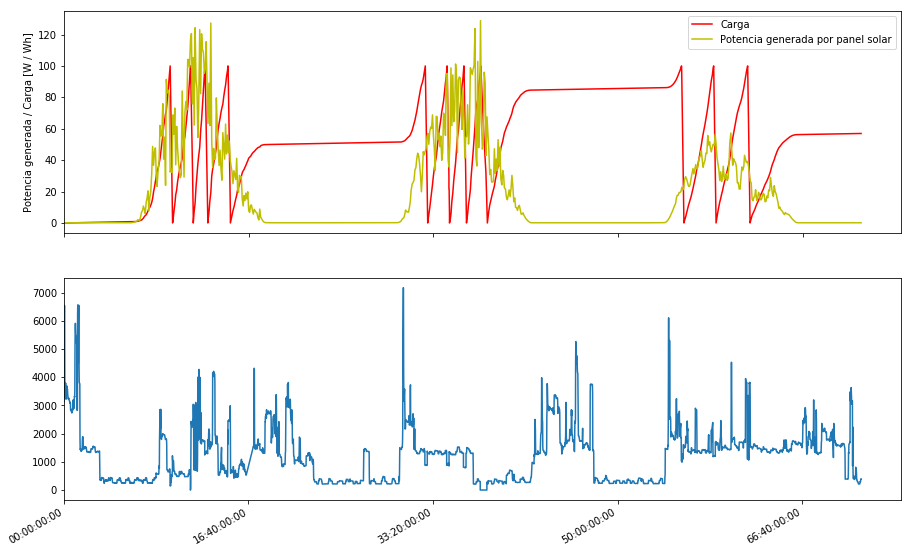

In [60]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (15,10))

ax[0].plot(chargeChanges.time, chargeChanges.charge, color='r', label='Carga')
ax[0].plot(generatedSolarPower.time, generatedSolarPower.value, color='y', label='Potencia generada por panel solar')

ax[0].set_xlim(left=0)

ax[0].set_xlabel('Tiempo [DEVS time]')
ax[0].set_ylabel('Potencia generada / Carga [W / Wh]')

ax[0].legend()

ax[1].plot(gridOutData.time, gridOutData.value, label='Potencia pedida a la red')
ax[1].set_xlim(left=0)
ax[1].xaxis.set_major_formatter(ticker.FuncFormatter(format_date))
ax[1].legend()

fig.autofmt_xdate()

plt.show()